# This analysis: % K-mer containment comparison

Sketch of the problem:
* To find out the assembly information-loss, we aligned mapped-reads to metagenome assembly
* and found out most of them with coverage >5x aligned to metagenome assembly
* indicating here is not much of information-loss for reads with > 5x cov

Questions:
* We then try to see if we can recover more reads with using metagenome assembly instead of GTDB as referece
* we conducted containment search each genome in:
* 1) raw metagenome, 2) assembled metagenome, 3) the reads mapped to the assembled metagenome

Data analysis:
* df1: summary.csv with coverage
* df2: containment search
* merge two dfs 

Refer: 
* "atta" notes: https://hackmd.io/ZlvQQM0NRxiYnF1QYtlVOA#6-atta-align-trimmed-reads-to-metagenome-assembly
* Snakefile for generating .csv: https://github.com/jeanzzhao/onehuman/blob/main/atta/Snakefile
* '*.trim.csv' files are under Farm ~/2022-assemblyloss/onehuman/atta/ and download in local folder

In [51]:
import glob
import os.path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
csv_prefixes = glob.glob ('/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/*.trim.csv')

In [3]:
csv_prefixes2 = [ x[:-9] for x in csv_prefixes ]
csv_prefixes2[:5]

['/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/ERR505104.x.GCF_001073155.1',
 '/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/ERR505104.x.GCF_024460435.1',
 '/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/ERR505104.x.GCF_015560355.1',
 '/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/ERR505104.x.GCA_000436175.1',
 '/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/ERR505104.x.GCA_018374955.1']

In [4]:
def get_genome_metagenome(prefix):
    prefix = os.path.basename(prefix)
    metagenome, _, genome, _, = prefix.split('.', 3)    
#    metagenome, _, genome = prefix.split('.', 2)
    return genome, metagenome

get_genome_metagenome(csv_prefixes2[0])

('GCF_001073155', 'ERR505104')

In [5]:
def load_triple(prefix):
    try:
        df1 = pd.read_csv(prefix + '.trim.csv')
        df2 = pd.read_csv(prefix + '.assem.csv')
        df3 = pd.read_csv(prefix + '.mapassem.csv')

        # should only be one entry in each
        assert len(df1) == 1
        assert len(df2) == 1
        assert len(df3) == 1

        trim_cont = list(df1.similarity)[0]
        assem_cont = list(df2.similarity)[0]
        mapassem_cont = list(df3.similarity)[0]

        genome, metagenome = get_genome_metagenome(prefix)

        d = dict(genome=genome, metagenome=metagenome, trim_cont=trim_cont,
                assem_cont=assem_cont, mapassem_cont=mapassem_cont)

        return d
    except pd.errors.EmptyDataError:
        return None
    
x = load_triple(csv_prefixes2[0])

In [6]:
x

{'genome': 'GCF_001073155',
 'metagenome': 'ERR505104',
 'trim_cont': 0.0648910411622276,
 'assem_cont': 0.0024213075060532,
 'mapassem_cont': 0.0053268765133171}

In [7]:
xx = [ load_triple(prefix) for prefix in csv_prefixes2 ]
xx = [ x for x in xx if x ]

In [8]:
len(xx)

230

In [45]:
df2 = pd.DataFrame.from_dict(xx)
df2

,genome,metagenome,trim_cont,assem_cont,mapassem_cont
0,GCF_001073155,ERR505104,0.064891,0.002421,0.005327
1,GCF_024460435,ERR505104,0.097281,0.052239,0.065832
2,GCF_015560355,ERR505104,0.056238,0.018436,0.024953
3,GCA_000436175,ERR505104,0.683255,0.654922,0.663276
4,GCA_018374955,ERR505104,0.235563,0.080903,0.106632
...,...,...,...,...,...
225,GCF_003478035,ERR505104,0.205579,0.077545,0.094561
226,GCA_905201495,ERR505104,0.041226,0.004832,0.006040
227,GCA_019417795,ERR505104,0.228688,0.140941,0.160264
228,GCA_000577295,ERR505104,0.504624,0.495538,0.499757


/var/folders/jd/_vtl887d0d30s68thpjrfcm00000gq/T/ipykernel_25753/2590157125.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labels)


[Text(0.5, 0, ''),
 Text(1.0, 0, 'Trimmed'),
 Text(1.5, 0, ''),
 Text(2.0, 0, 'Assembled'),
 Text(2.5, 0, ''),
 Text(3.0, 0, 'MapToAssembly'),
 Text(3.5, 0, '')]

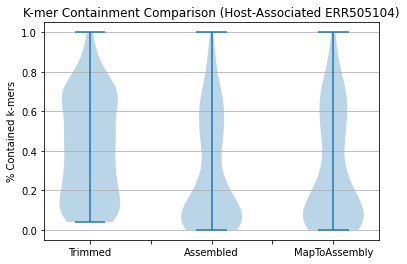

In [76]:
# compare K-mer containment, many trimmed reads that align to genome got lost after assembly
# align trimmed reads to assembled genome did not recover
fig, axes = plt.subplots()
axes.violinplot(dataset = [df2.trim_cont, df2.assem_cont, df2.mapassem_cont])

axes.set_title('K-mer Containment Comparison (Host-Associated ERR505104)')
axes.yaxis.grid(True)
axes.set_ylabel('% Contained k-mers')
axes.set_xticklabels([])
labels = ['', 'Trimmed', '', 'Assembled', '', 'MapToAssembly']
axes.set_xticklabels(labels)


In [108]:
# pull .summary.csv file
metagenome="ERR505104"
filename = f"/Users/ZYZhao/projects/AL/human/ERR505104/Analysis/{metagenome}.summary.csv"
df1 = pd.read_csv(filename)

# Merge DataFrames based on the 'key' column
df = pd.merge(df1, df2, on='genome', how='inner')  # Inner join on 'key'

#bins = [0, 10, 20, 50, 100, float ('inf')]
#labels = ['<10', '10-20', '20-50', '50-100', '>100']

# Categorize effective coverage into coverage categories
#df['coverage_category'] = pd.cut(df['effective_coverage'], bins=bins, labels=labels, right=False)
df

,genome,n_chrom,n_snps,n_genome_bp,n_missed_bp,f_missed_bp,n_covered_bp,f_covered_bp,avg_coverage,effective_coverage,...,% assembled,n_diff3_read,% map_to_assembly,metagenome,trim_cont,assem_cont,mapassem_cont,assem_v_trim,mapassem_v_trim,mapassem_v_assem
0,GCF_000273055,17,12555,6060928,652281,0.107621,5408647,0.892379,324.088288,363.173226,...,99.58%,402853,97.98%,ERR505104,0.880286,0.875171,0.878752,0.005116,0.001535,0.003581
1,GCF_021409785,168,25750,5730670,744406,0.129899,4986264,0.870101,307.108108,352.956687,...,99.24%,1885,99.99%,ERR505104,0.783765,0.779102,0.783247,0.004663,0.000518,0.004145
2,GCF_003464725,100,35171,5606424,709703,0.126587,4896721,0.873413,297.707714,340.855783,...,99.36%,1948,99.99%,ERR505104,0.755229,0.747076,0.753279,0.008153,0.001950,0.006203
3,GCF_019128215,149,126259,5325342,1176617,0.220947,4148725,0.779053,243.115422,312.065217,...,98.24%,126021,99.06%,ERR505104,0.393837,0.376174,0.389327,0.017663,0.004510,0.013153
4,GCF_015561145,91,7859,5270526,657193,0.124692,4613333,0.875308,190.504259,217.642570,...,96.95%,29211,99.72%,ERR505104,0.862927,0.848275,0.852901,0.014652,0.010025,0.004627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,GCA_944377425,99,3376,2406848,2032085,0.844293,374763,0.155707,0.299973,1.926522,...,6.66%,4348,53.67%,ERR505104,0.079834,0.001663,0.001663,0.078170,0.078170,0.000000
226,GCA_905212385,64,8190,1557628,727475,0.467040,830153,0.532960,1.018721,1.911440,...,22.06%,12649,26.08%,ERR505104,0.324204,0.031847,0.034395,0.292357,0.289809,0.002548
227,GCF_010590175,97,1195,5361690,4739826,0.884017,621864,0.115983,0.211912,1.827100,...,27.10%,7874,40.89%,ERR505104,0.085976,0.001146,0.001337,0.084830,0.084639,0.000191
228,GCA_905209085,15,1901,3086275,2743518,0.888942,342757,0.111058,0.192717,1.735279,...,2.57%,4356,45.82%,ERR505104,0.067227,0.002262,0.002586,0.064964,0.064641,0.000323


/var/folders/jd/_vtl887d0d30s68thpjrfcm00000gq/T/ipykernel_25753/1855760964.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labels)


[Text(0.5, 0, ''),
 Text(1.0, 0, 'Trimmed'),
 Text(1.5, 0, ''),
 Text(2.0, 0, 'Assembled'),
 Text(2.5, 0, ''),
 Text(3.0, 0, 'MapToAssembly'),
 Text(3.5, 0, '')]

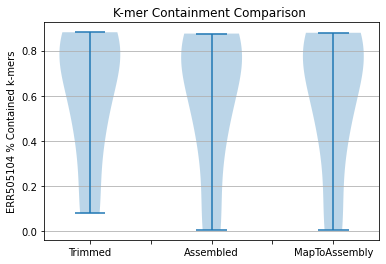

In [75]:
# when cov > 50, no difference among 1) trim-align-to-GTDB reads, 2) assembled reads, 3) trim-align-to-assembly reads
df_cov50 = df[(df['effective_coverage'] >= 50)]
fig, axes = plt.subplots()
axes.violinplot(dataset = [df_cov50.trim_cont, df_cov50.assem_cont, df_cov50.mapassem_cont])

axes.set_title('K-mer Containment Comparison ')
axes.yaxis.grid(True)
axes.set_ylabel('ERR505104 % Contained k-mers')
axes.set_xticklabels([])
labels = ['', 'Trimmed', '', 'Assembled', '', 'MapToAssembly']
axes.set_xticklabels(labels)

/var/folders/jd/_vtl887d0d30s68thpjrfcm00000gq/T/ipykernel_25753/2059618397.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labels)


[Text(0.5, 0, ''),
 Text(1.0, 0, 'Trimmed'),
 Text(1.5, 0, ''),
 Text(2.0, 0, 'Assembled'),
 Text(2.5, 0, ''),
 Text(3.0, 0, 'MapToAssembly'),
 Text(3.5, 0, '')]

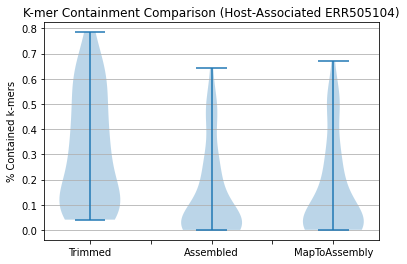

In [112]:
# when cov<10, ~ <20% K-mer retained in assembly, align-to-assembly did not recover the assembly loss
df_cov10less = df[(df['effective_coverage'] <10)]
fig, axes = plt.subplots()
axes.violinplot(dataset = [df_cov10less.trim_cont, df_cov10less.assem_cont, df_cov10less.mapassem_cont])

axes.set_title('K-mer Containment Comparison (Host-Associated ERR505104)')
axes.yaxis.grid(True)
axes.set_ylabel('% Contained k-mers')
axes.set_xticklabels([])
labels = ['', 'Trimmed', '', 'Assembled', '', 'MapToAssembly']
axes.set_xticklabels(labels)
# 

In [109]:
# If we subtract one vs another, can we better visualize the difference among them?
df['assem_v_trim'] = df['trim_cont'] - df['assem_cont']
# this value indicates the assembly-loss, the higher the value, the more information loss

df['mapassem_v_trim'] = df['trim_cont'] - df['mapassem_cont']
# loss when align reads to metagenome assembly too? --> Yes, indicating the loss happened in the assembly step

df['mapassem_v_assem'] = df['mapassem_cont'] - df['assem_cont']
# if so, what would be the differences between using GTDB vs. assembly as ref

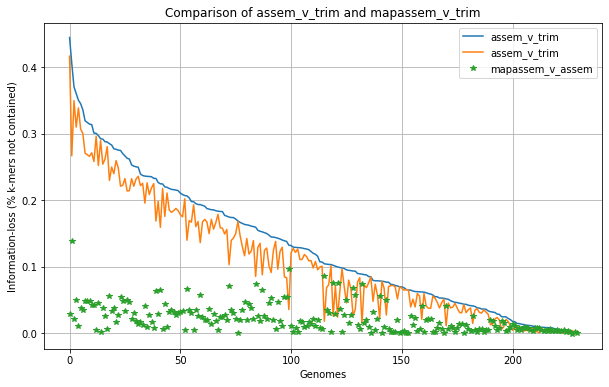

In [117]:
# If we sort one value as a baseline, then plot the other value on top of that
df = df.sort_values(by='assem_v_trim', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.plot(df.assem_v_trim, label='assem_v_trim')
plt.plot(df.mapassem_v_trim, label='assem_v_trim')
plt.plot(df.mapassem_v_assem, "*", label='mapassem_v_assem')

plt.xlabel('Genomes')
plt.ylabel('Information-loss (% k-mers not contained)')
plt.title('Comparison of assem_v_trim and mapassem_v_trim')
plt.legend()
plt.grid(True)
plt.show()

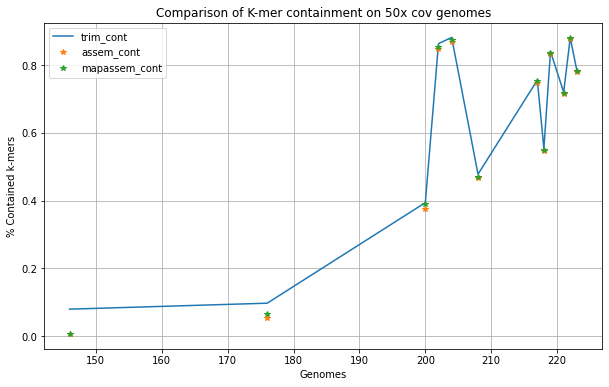

In [118]:

df_cov50 = df[(df['effective_coverage'] >= 50)]
df_cov50

plt.figure(figsize=(10, 6))
#plt.plot(df_cov50.mapassem_v_assem, "*", label='mapassem_v_assem')
#plt.plot(df_cov50.assem_v_trim, "*", label='assem_v_trim')
#plt.plot(df_cov50.mapassem_v_trim, "*",label='mapassem_v_trim')

plt.plot(df_cov50.index, df_cov50.trim_cont, label='trim_cont')
plt.plot(df_cov50.assem_cont, "*", label='assem_cont')
plt.plot(df_cov50.mapassem_cont, "*", label='mapassem_cont')
plt.xlabel('Genomes')
plt.ylabel('% Contained k-mers')
plt.title('Comparison of K-mer containment on 50x cov genomes')
plt.legend()
plt.grid(True)
plt.show()

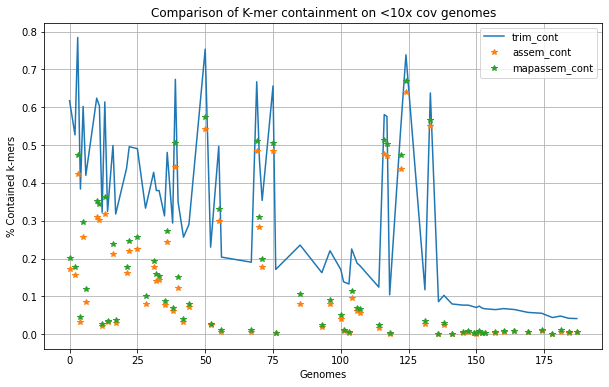

In [120]:

df_cov10less = df[(df['effective_coverage'] <10)]
df_cov10less

plt.figure(figsize=(10, 6))
plt.plot(df_cov10less.index, df_cov10less.trim_cont, label='trim_cont')
plt.plot(df_cov10less.assem_cont, "*", label='assem_cont')
plt.plot(df_cov10less.mapassem_cont, "*", label='mapassem_cont')
plt.xlabel('Genomes')
plt.ylabel('% Contained k-mers')
plt.title('Comparison of K-mer containment on <10x cov genomes')
plt.legend()
plt.grid(True)
plt.show()